### Week 4 - Homework

In [86]:
import pandas as pd 
import numpy as np 
import sys, os

from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

%matplotlib inline

Data Preperation

In [3]:
cols = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style',
       'highway MPG', 'city mpg', 'MSRP']

data = pd.read_csv(r'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')[cols]

In [4]:
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'msrp'],
      dtype='object')

In [5]:
data.isnull().any()

make                 False
model                False
year                 False
engine_hp             True
engine_cylinders      True
transmission_type    False
vehicle_style        False
highway_mpg          False
city_mpg             False
msrp                 False
dtype: bool

In [6]:
data = data.fillna(0)
data.isnull().any()

make                 False
model                False
year                 False
engine_hp            False
engine_cylinders     False
transmission_type    False
vehicle_style        False
highway_mpg          False
city_mpg             False
msrp                 False
dtype: bool

In [7]:
msrp_mean = data['msrp'].mean()
data['above_average'] = data['msrp'].apply(lambda x: 1 if x > msrp_mean else 0)

Split Dataset

In [41]:
y = data.above_average.values 
X = data.drop(['msrp', 'above_average'], axis=1)

X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

#### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

For each numerical variable, use it as score and compute AUC with the above_average variable. Use the training dataset for this task.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [42]:
numerical_cols = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

auc_dict = {}

for col in numerical_cols:
    auc_score = roc_auc_score(y_train, X_train[col].values)
    
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -X_train[col].values)

    auc_dict[col] = auc_score 



In [43]:
print(f"The numerical variable that has the highest AUC: {max(auc_dict, key= lambda x: auc_dict[x])}")

The numerical variable that has the highest AUC: engine_hp


#### Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

In [44]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1_000)
dv = DictVectorizer(sparse=False)

In [48]:
X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))

model.fit(X_train_enc, y_train)

X_val_enc = dv.transform(X_val.to_dict(orient='records'))

y_pred_val = model.predict_proba(X_val_enc)[:, 1]

auc_score = round(roc_auc_score(y_val, y_pred_val), 3)

In [49]:
print(f"The AUC score is: {auc_score}")

The AUC score is: 0.979


#### Question 3: Precision and Recall

Compute precision and recall for the model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall

In [63]:
thresholds = np.linspace(0, 1, 101)
precision_scores = []
recall_scores = []

for t in thresholds:
    print(t)
    y_pred = (y_pred_val >= t)

    prec_score = precision_score(y_val, y_pred)
    rec_score = recall_score(y_val, y_pred)

    precision_scores.append(prec_score)
    recall_scores.append(rec_score)

    

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99
1.0


c:\Users\khanm375\Documents\ml_zoom\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


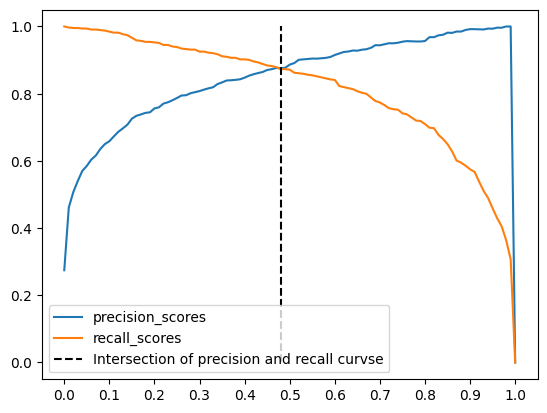

In [72]:
plt.plot(thresholds, precision_scores, label='precision_scores')
plt.plot(thresholds, recall_scores, label='recall_scores')
plt.vlines(x = 0.48, ymin = 0, ymax = max(recall_scores), linestyles= 'dashed' , colors='black', label = 'Intersection of precision and recall curvse')
plt.xticks(np.arange(0, 1.01, 0.1))
plt.legend()

The precision and recall curves intersect at 0.48 threshold.

#### Question 4: F1 score

Compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [78]:
def f1_score(precision: float, recall: float) -> float:
    return 2 * ((precision * recall) / (precision + recall))

In [81]:
thresholds = np.linspace(0, 1, 101)
threshold_f1_score = {}

for t in thresholds:
    y_pred = (y_pred_val >= t)

    prec_score = precision_score(y_val, y_pred)
    rec_score = recall_score(y_val, y_pred)
    
    f1_scores = f1_score(prec_score, rec_score)

    threshold_f1_score[t] = f1_scores


c:\Users\khanm375\Documents\ml_zoom\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\khanm375\AppData\Local\Temp\ipykernel_55144\918560129.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return 2 * ((precision * recall) / (precision + recall))


In [85]:
max_f1_score = max(threshold_f1_score, key = lambda x: threshold_f1_score[x])
print(f"The threshold with the max f1_score is: {max_f1_score}")

The threshold with the max f1_score is: 0.52


#### Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds


In [94]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(X_full_train):
    #split into train and validation
    X_train = X_full_train.iloc[train_idx]
    X_val = X_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1_000)
    dv = DictVectorizer(sparse=False)

    X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))
    model.fit(X_train_enc, y_train)

    X_val_enc = dv.transform(X_val.to_dict(orient='records'))

    y_pred = model.predict_proba(X_val_enc)[:, 1]

    auc_score = roc_auc_score(y_val, y_pred)
    scores.append(auc_score)


In [96]:
auc_std_score = round(np.std(scores),3)

In [98]:
print(f"The AUC standard deviation across the 5 folds is: {auc_std_score}")

The AUC standard deviation across the 5 folds is: 0.003


#### Question 6: Hyperparameter Tuning

Use 5-Fold cross-validation to find the best parameter C

In [99]:
C_vals = [0.01, 0.1, 0.5, 10]

C_mean = {}
C_std = {}

for C_val in C_vals:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(X_full_train):
        #split into train and validation
        X_train = X_full_train.iloc[train_idx]
        X_val = X_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        model = LogisticRegression(solver='liblinear', C=C_val, max_iter=1_000)
        dv = DictVectorizer(sparse=False)

        X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))
        model.fit(X_train_enc, y_train)

        X_val_enc = dv.transform(X_val.to_dict(orient='records'))

        y_pred = model.predict_proba(X_val_enc)[:, 1]

        auc_score = roc_auc_score(y_val, y_pred)
        scores.append(auc_score)
    
    C_mean[C_val] = round(np.mean(scores), 3)
    C_std[C_val] = round(np.std(scores), 3)


In [101]:
max_C_mean = max(C_mean, key = lambda x: C_mean[x])

print(f"The C value that leads to the best mean score is: {max_C_mean}")

The C value that leads to the best mean score is: 10
